# Field of View Visualization Notebook
This Jupyter Notebook is meant to illustrate how the SatChecker FOV API (https://satchecker.cps.iau.org/fov) can be used with python/astropy to visualize satellite passes within a field of view.

#### Note about TLE accuracy:
It's important to note that TLE accuracy varies and can impact predicted satellite positions. Public Space-Track TLEs for LEO satellites are often off by several arcminutes, and in occasional cases, errors can reach up to a degree, even for recent data. Accuracy tends to degrade with time since the TLE was issued and can also be affected by conditions like space weather. Occasionally, TLEs are systematically incorrect and later corrected.

SatChecker draws from both Space-Track and CelesTrak, the latter of which includes supplemental TLEs from satellite operators such as SpaceX and Amazon, which can sometimes incorporate maneuvers and updates. 

In [79]:
# FOV Visualization Notebook
# This Jupyter Notebook demonstrates how to visualize satellite positions 
# from the SatChecker FOV API using astropy

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

%matplotlib inline


In [76]:
# Set up the FOV query parameters
mid_obs_time_jd = 2460584.519211  # Example JD
duration = 30  # seconds
ra_center = 224.048903  # Center RA in degrees
dec_center = 78.778084  # Center Dec in degrees
fov_radius = 5  # FOV radius in degrees
latitude = 43
longitude = -81
elevation = 300 # meters

# Make the API request
response = requests.get(
    f"https://dev.satchecker.cps.iau.noirlab.edu/fov/satellite-passes/?latitude={latitude}&longitude={longitude}&elevation={elevation}&mid_obs_time_jd={mid_obs_time_jd}&duration={duration}&ra={ra_center}&dec={dec_center}&fov_radius={fov_radius}&group_by=satellite",
    timeout=60
)
data = response.json()

In [77]:
# Extract RA/Dec positions for each satellite
satellites = {}

for sat_key, sat_data in data['data']['satellites'].items():
    if sat_key not in satellites:
        satellites[sat_key] = []
    
    # Add ra, dec, and julian_date from each position
    for position in sat_data['positions']:
        satellites[sat_key].append([
            position['ra'],
            position['dec'],
            position['julian_date']
        ])
    
# Verify data
for sat in satellites:
    print(f"\n{sat}:")
    print(f"Number of points: {len(satellites[sat])}")


COSMOS 839 DEB (10439):
Number of points: 4

CZ-6A DEB (55190):
Number of points: 18

THOR ABLESTAR DEB (134):
Number of points: 30


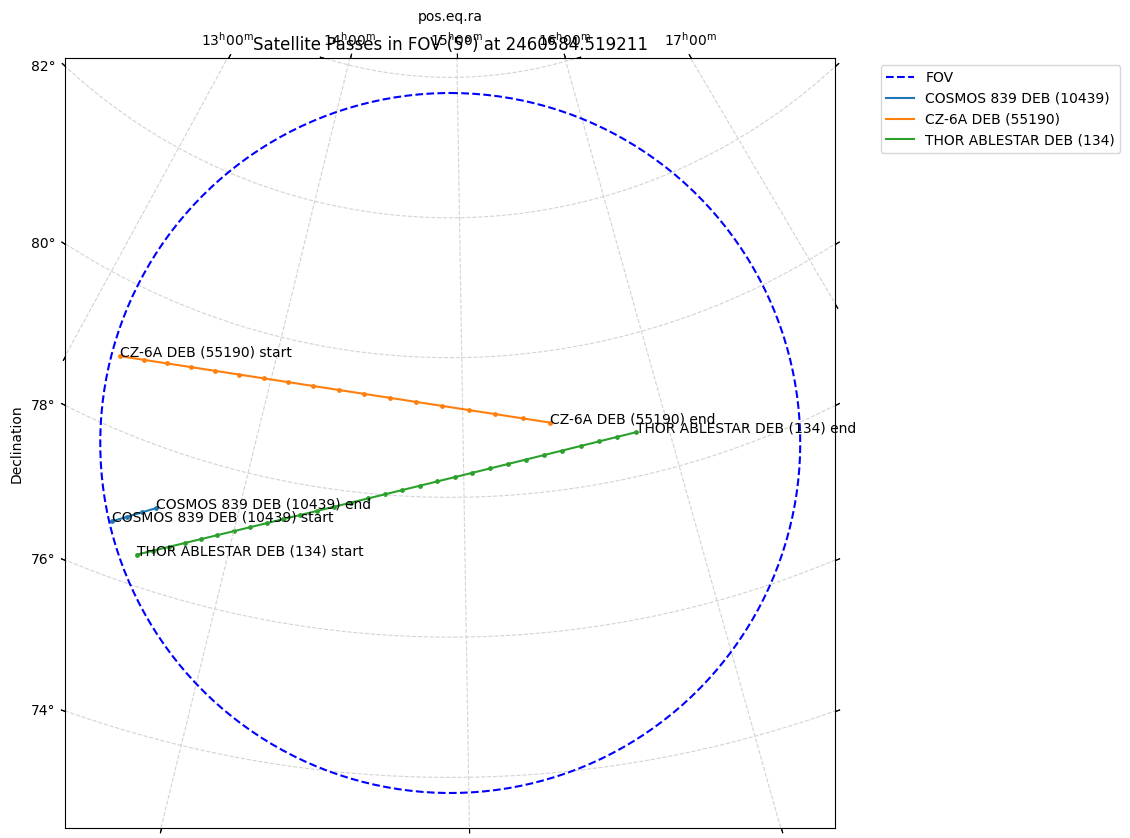

In [78]:
# Create a simple WCS 
wcs = WCS(naxis=2)
wcs.wcs.crpix = [0, 0]
wcs.wcs.crval = [ra_center, dec_center]
wcs.wcs.cdelt = [0.1, 0.1]
wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']

# Create plot with WCS axes
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
center = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg, frame='icrs')

position_angles = np.linspace(0, 360, 360) * u.deg
circle_points = center.directional_offset_by(position_angles, fov_radius * u.deg)

# Plot the FOV circle
ax.plot(circle_points.ra.deg, circle_points.dec.deg, 
        'b--', label='FOV', transform=ax.get_transform('world'))


# Plot coordinates
for sat_name in satellites.keys():
    ra = [pos[0] for pos in satellites[sat_name]]
    dec = [pos[1] for pos in satellites[sat_name]]
    
    

    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    # Satellite track
    ax.plot(coords.ra.deg, coords.dec.deg, 
            transform=ax.get_transform('world'),
            label=sat_name)
    
    # Satellite position points
    ax.scatter(coords.ra.deg, coords.dec.deg, 
               transform=ax.get_transform('world'), s=6)
    
    # Optional: Add start and end labels
    # Comment out if not needed
    times = [pos[2] for pos in satellites[sat_name]]
    if coords.ra.deg[0] < coords.ra.deg[-1]:
        ax.text(
            coords.ra.deg[0], coords.dec.deg[0], f'{sat_name} start', 
            transform=ax.get_transform('world')
                )  
        ax.text(
            coords.ra.deg[-1], coords.dec.deg[-1], f'{sat_name} end', 
            transform=ax.get_transform('world')
        )
    else:
        ax.text(
            coords.ra.deg[0], coords.dec.deg[0], f'{sat_name} end', 
            transform=ax.get_transform('world')
        )
        ax.text(
            coords.ra.deg[-1], coords.dec.deg[-1], f'{sat_name} start', 
            transform=ax.get_transform('world')
        )


ax.set_aspect('equal')  # Force equal aspect ratio
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(f'Satellite Passes in FOV ({fov_radius}°) at {mid_obs_time_jd}')
ax.grid(color='lightgray', linestyle='--')

plt.show()